# Init

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, '../src')

In [3]:
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_t

In [ ]:
import numpy as onp

import jax
from jax.random import split
from jax.tree_util import Partial as partial
from jax import ops, nn, jit, grad, value_and_grad, lax, vmap, random, numpy as jnp
from jax.image import resize as im_resize

from jax.experimental import optix
from jax.experimental import optimizers
from jax.experimental import stax # neural network library

import tensorflow_datasets as tfds


import matplotlib.pyplot as plt

# platform = "cpu"
# jax.config.update('jax_platform_name', platform)

In [ ]:
jax.devices()[0]

In [ ]:
rng = random.PRNGKey(0)

In [ ]:
def flatten(array, dims=None):
    shape = array.shape
    if dims is None:
        return array.reshape(-1)
    elif isinstance(dims, tuple):
        assert (0 <= dims[0] < len(shape)) and (0 <= dims[1] < len(shape))
        final_shape = (*shape[:dims[0]], onp.prod(shape[dims[0]:dims[1] + 1]), *shape[dims[1] + 1:])
        return array.reshape(final_shape)
    else:
        assert 0 <= dims < len(shape)
        final_shape = (onp.prod(shape[:dims + 1]), *shape[dims + 1:])
        return array.reshape(final_shape)

# Data

In [ ]:
mean28, std28 = (0.9220594763755798, 0.2477845698595047)
mean84, std84 = (0.9220604300498962, 0.2642029821872711)

In [ ]:
from PIL import Image

def prepare_omniglot_data(split="train", resize=(28, 28), normalize=False, convert="L"):
    data, = tfds.as_numpy(
        tfds.load(
            name="omniglot", shuffle_files=False, batch_size=-1, split=[split],
    ))

    if resize or convert:
        to_pil = lambda x: Image.fromarray(x)
        if convert:
            _convert = lambda x: to_pil(x).convert(convert)
        else:
            _convert = lambda x: to_pil(x)
        if resize:
            _resize = lambda x: _convert(x).resize(resize, Image.LANCZOS)
        else:
            _resize = lambda x: _convert(x)
        transform = _resize
        images = onp.stack([transform(img) for img in tqdm(data["image"])])
    else:
        images = data["image"]

    images = images / 255
    labels = data["label"]
    order = onp.argsort(labels)
    uniques, counts = onp.unique(labels, return_counts=True)
    assert (counts[0] == counts).all()
    
    images = images[order]
    images = images.reshape(len(uniques), counts[0], *images.shape[1:])
    labels = labels[order].reshape(len(uniques), counts[0], *labels.shape[1:])
    
    return images, labels

In [ ]:
# def prepare_omniglot_data(split="train", resize=(28, 28), normalize=True):
    
#     data, = tfds.as_numpy(
#         tfds.load(
#             name="omniglot", shuffle_files=False, batch_size=-1, split=[split],
#     ))
    
#     images = (data["image"][:, :, :, [0]]) / 255, device="cpu"
#     if resize:
#          images = vmap(lambda img: im_resize(img, (*resize, 1), "lanczos5"))(images)
#     if normalize:
#         if normalize is True:
#             mean, std = images.mean(), images.std()
#         else:
#             mean, std = normalize
#         images = (images - mean) / std
#     labels = jnp.array(data["label"])
#     order = jnp.argsort(labels)
#     uniques, counts = jnp.unique(labels, return_counts=True)
#     assert (counts[0] == counts).all()
    
#     images = images[order]
#     images = images.reshape(len(uniques), counts[0], *images.shape[1:])
#     labels = labels[order].reshape(len(uniques), counts[0], *labels.shape[1:])
    
#     return images, labels

In [ ]:
size = 28
if size == 28:
    train_images, train_labels = prepare_omniglot_data(normalize=False, resize=(28, 28))
elif size == 84:
    train_images, train_labels = prepare_omniglot_data(normalize=False, resize=(84, 84))

In [ ]:
train_images = train_images[..., None] # Unsqueeze

train_split = 660
val_images, val_labels = train_images[train_split:], train_labels[train_split:]
train_images, train_labels = train_images[:train_split], train_labels[:train_split]

train_images, train_labels = jax.device_put(train_images), jax.device_put(train_labels)
val_images, val_labels = jax.device_put(val_images), jax.device_put(val_labels)

mean, std = train_images.mean(), train_images.std()
print("Mean, stddev")
print(mean, std)

train_images = (train_images - mean) / std
val_images = (val_images - mean) / std

print()
print("Train split")
print("Images and labels shape")
print(train_images.shape, train_labels.shape)
print("Mean and stddev")
print(train_images.mean(), train_images.std())

print()
print("val split")
print("Images and labels shape")
print(val_images.shape, val_labels.shape)
print("Mean and stddev")
print(val_images.mean(), val_images.std())

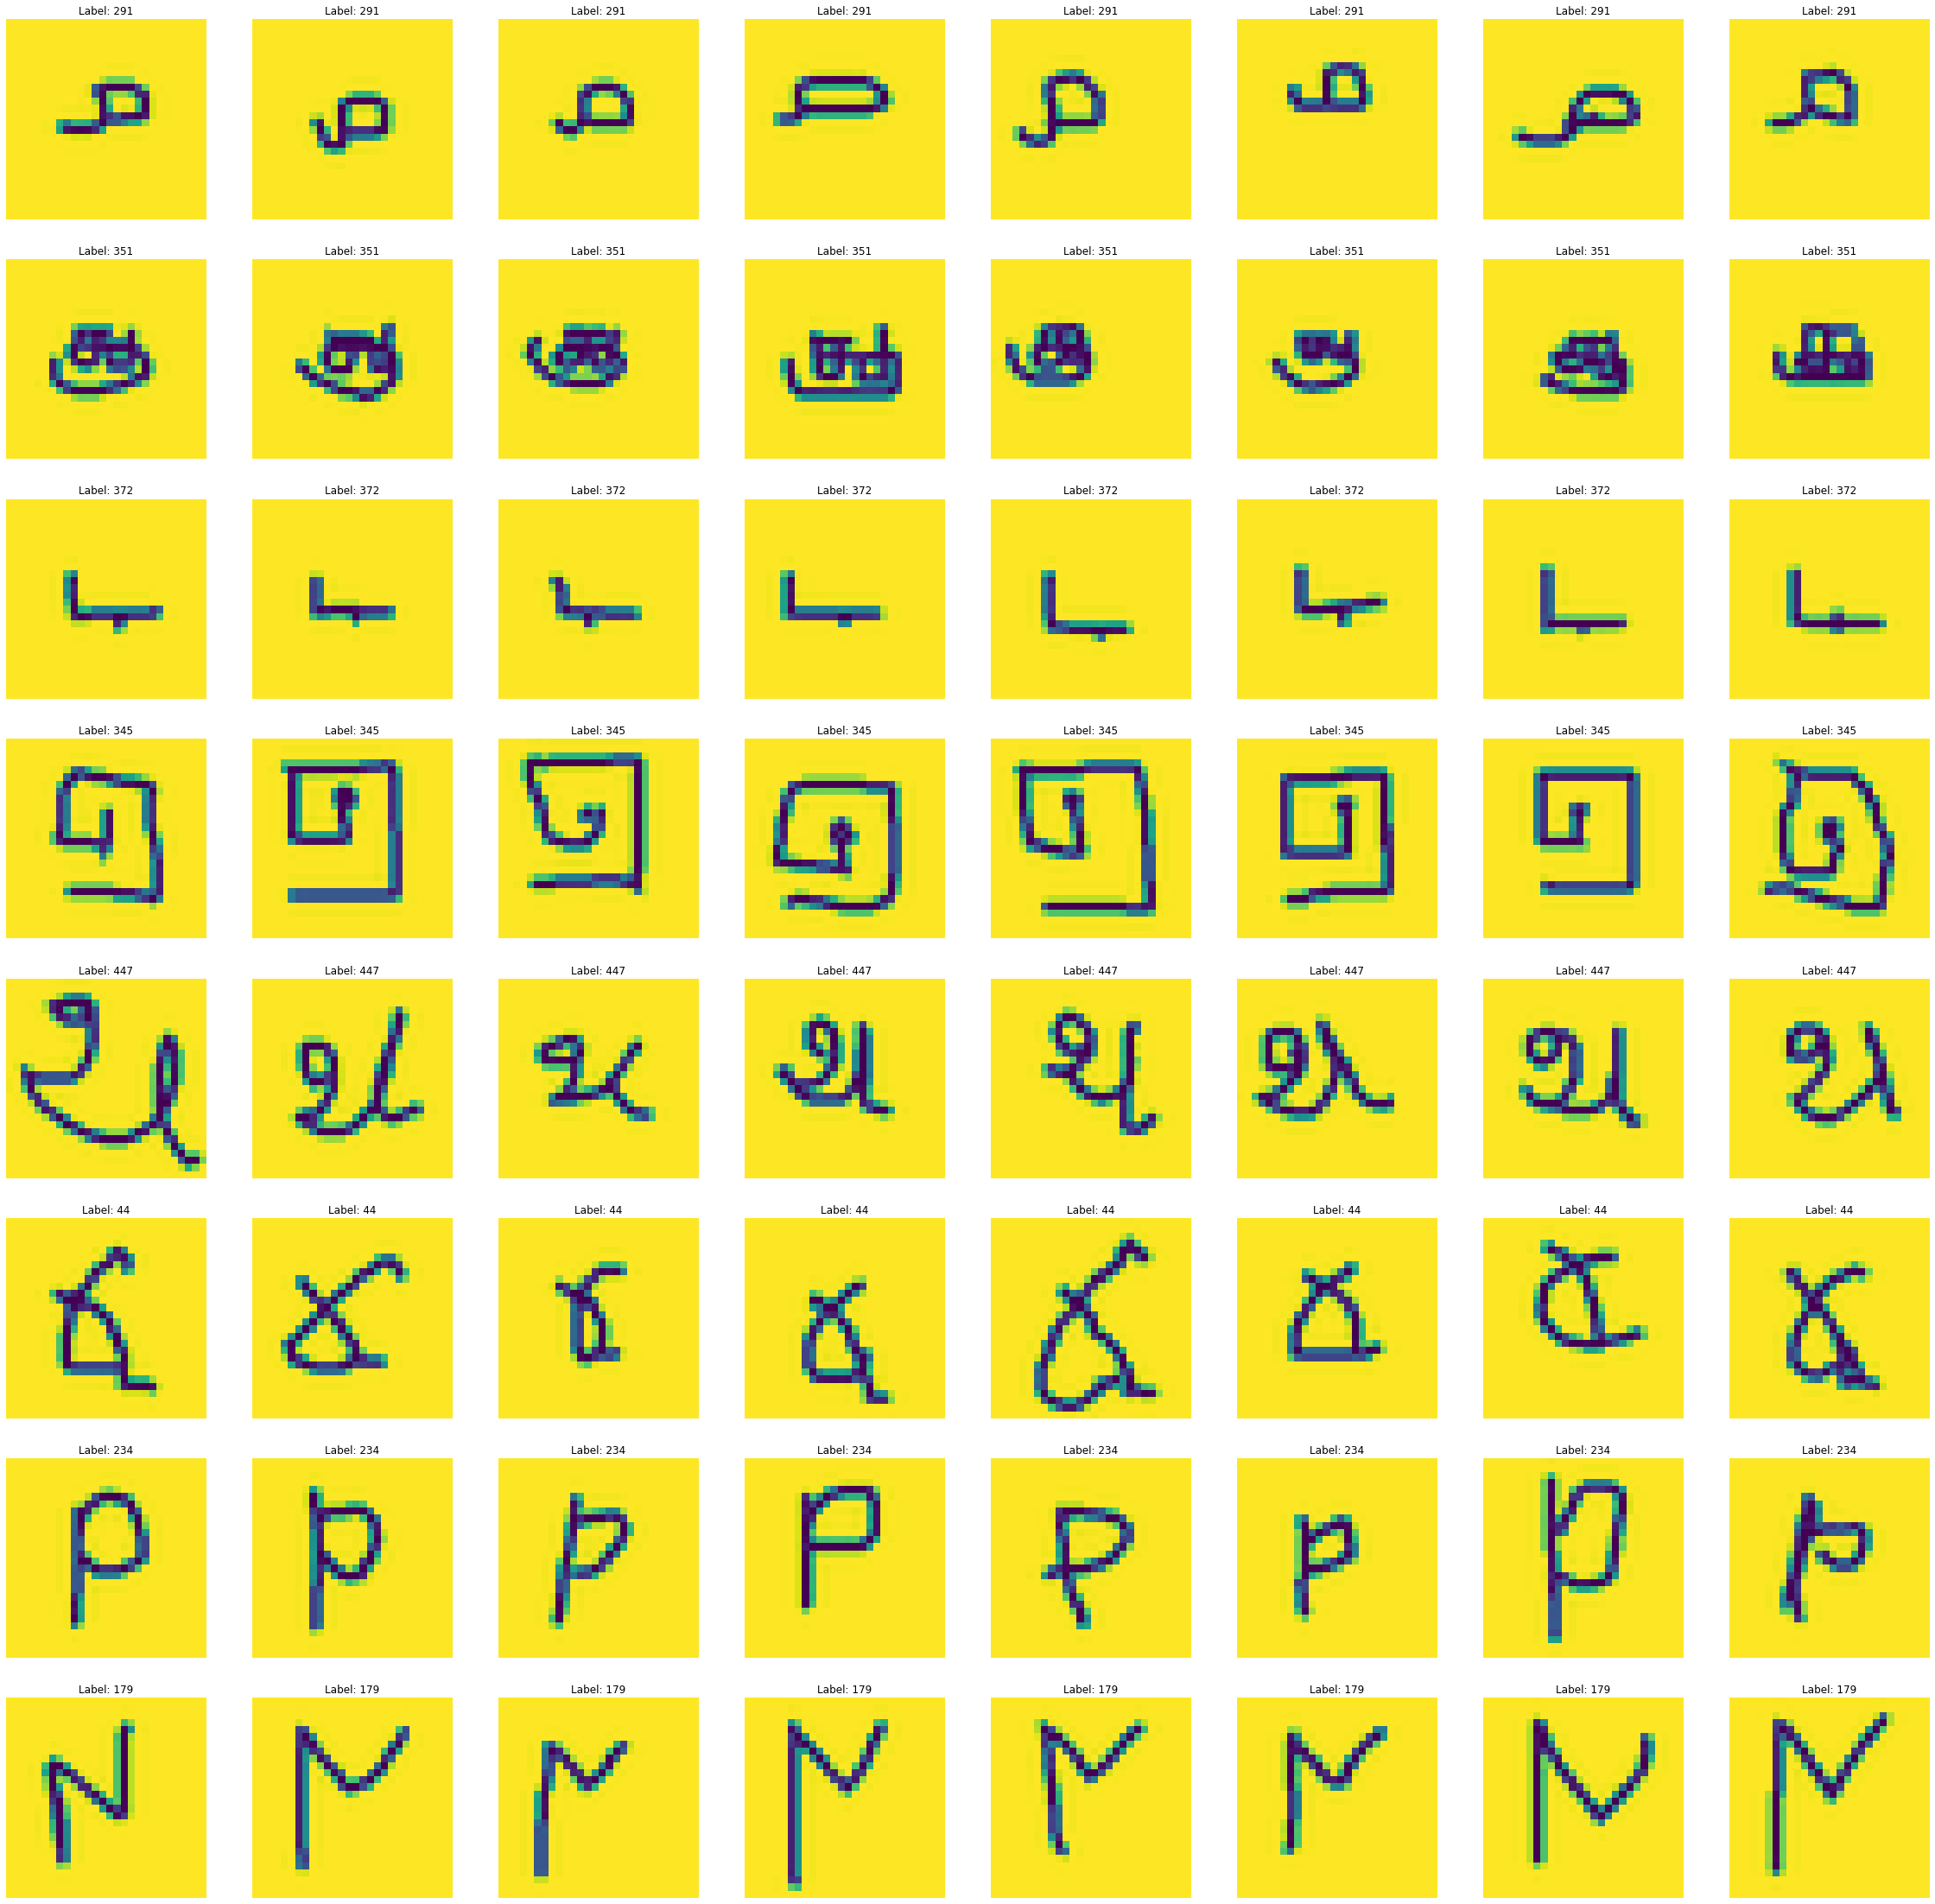

In [52]:
nrows = 8
ncols = 8
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols, 5 * nrows))
selected_classes = onp.random.choice(onp.arange(train_labels.shape[0]), nrows, replace=False)
for i in range(nrows):
    selected_imgs = onp.random.choice(onp.arange(20), ncols, replace=False)
    for j in range(ncols):
        ax = axes[i, j]
        ax.imshow(train_images[selected_classes[i], selected_imgs[j], :, :, 0])
        ax.set_title("Label: %d" % train_labels[selected_classes[i], selected_imgs[j]])
        ax.set_axis_off()
        
# plt.tight_layout()

# Samplers

In [ ]:
def _choice(rng, x, y, num_samples):
    idxs = random.choice(rng, jnp.arange(x.shape[0]), (num_samples,), replace=False)
    return x[idxs], y[idxs]

def _inner_loop_sampler(rng, images, labels, tasks, num_tasks, num_samples, shuffle=True):
    rng_tasks, rng_shuffle = split(rng)
    sampled_tasks = random.choice(rng_tasks, tasks, (num_tasks,), replace=False)
    if shuffle:
        sampled_images, labels = vmap(partial(_choice, num_samples=num_samples))(
            split(rng_shuffle, num_tasks), images[sampled_tasks], labels[sampled_tasks],
        )
    else:
        sampled_images = images[sampled_tasks, :num_samples]
        labels = labels[sampled_tasks, :num_samples]
    return sampled_images, labels

def _outer_loop_sampler(rng, images, labels, num_samples):
    _, rng = split(rng, 2)
    sampled_idxs = random.choice(rng, jnp.arange(images.shape[0]), (num_samples,), replace=False)
    return images[sampled_idxs], labels[sampled_idxs]

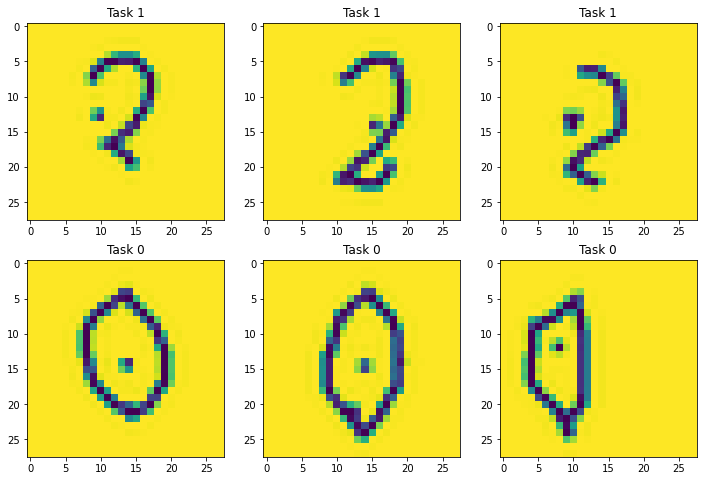

In [55]:
rng, rng_s = split(rng)
n_tasks = 2
n_samples = 3
_x, _y = _inner_loop_sampler(rng_s, train_images, train_labels, jnp.arange(2), n_tasks, n_samples, shuffle=True)

fig, axes = plt.subplots(ncols=n_samples, nrows=n_tasks, figsize=(4 * n_samples, 4 * n_tasks))
for i in range(n_tasks):
    for j in range(n_samples):
        ax = axes[i, j]
        ax.imshow(_x[i, j, :, :, 0])
        ax.set_title("Task %d" % _y[i, j])

# Model

In [ ]:
def Reshape(newshape):
    """Layer construction function for a reshape layer."""
    init_fun = lambda rng, input_shape: (newshape, ())
    apply_fun = lambda params, inputs, **kwargs: jnp.reshape(inputs, newshape)
    return init_fun, apply_fun

def DenseNoBias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
    """Layer constructor function for a dense (fully-connected) layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, = random.split(rng, 1)
        W = W_init(k1, (input_shape[-1], out_dim))
        return output_shape, (W,)
    def apply_fun(params, inputs, **kwargs):
        W, = params
        return jnp.dot(inputs, W)
    return init_fun, apply_fun

In [ ]:
num_channels = 256

if size == 28:
    strides = [(1, 1), (1, 1), (1, 1), (2, 2), (1, 1), (2, 2)]
elif size == 84:
    strides = [(2, 2), (1, 1), (2, 2), (1, 1), (2, 2), (2, 2)]

def make_conv(strides=None):
    return stax.Conv(
        out_chan=num_channels,
        filter_shape=(3, 3),
        padding="VALID",
        strides=strides,
        W_init=nn.initializers.he_normal(),
        b_init=nn.initializers.zeros,
    )

oml_rln_init, oml_rln_apply = stax.serial(
    make_conv(strides[0]), stax.Relu,
    make_conv(strides[1]), stax.Relu,
    make_conv(strides[2]), stax.Relu,
    make_conv(strides[3]), stax.Relu,
    make_conv(strides[4]), stax.Relu,
    make_conv(strides[5]), stax.Relu,  
    Reshape((-1, 9 * num_channels)),
    
)

oml_pln_init, oml_pln_apply = stax.serial(
    # *([stax.Dense(hidden_dim, W_init=nn.initializers.he_normal(), b_init=nn.initializers.zeros), stax.Relu] * num_pln_layers),
    # stax.Dense(1024, W_init=nn.initializers.he_normal(), b_init=nn.initializers.zeros),
    # stax.Relu,
    DenseNoBias(1000, W_init=nn.initializers.he_normal()),
    # stax.Dense(1000, W_init=nn.initializers.he_normal(), b_init=nn.initializers.zeros),
    stax.LogSoftmax,
)

def oml_net_init(rng, input_shape):
    rng_rln, rng_pln = split(rng, 2)
    rln_out_shape, rln_params = oml_rln_init(rng_rln, input_shape)
    pln_out_shape, pln_params = oml_pln_init(rng_pln, rln_out_shape)
    return (rln_out_shape, pln_out_shape), rln_params, pln_params

@jit
def oml_net_apply(rln_params, pln_params, inputs):
    return oml_pln_apply(pln_params, oml_rln_apply(rln_params, inputs))

@jit
def cross_entropy_loss(preds, targets):
    nll = -jnp.take_along_axis(preds, targets[..., None], axis=-1)
    return nll

def oml_net_xe_and_acc(rln_params, pln_params, inputs, targets):
    preds = oml_net_apply(rln_params, pln_params, inputs)
    acc = (preds.argmax(-1) == targets).astype(jnp.float32).mean()
    return cross_entropy_loss(preds, targets).mean(), acc

In [ ]:
in_size = (-1, size, size, 1)
(rln_out_shape, pln_out_shape), rln_params, pln_params = oml_net_init(rng, in_size)
print(in_size)
print(rln_out_shape, pln_out_shape)

oml_net_apply(rln_params, pln_params, train_images[0]);

# Train Loop

In [ ]:
def make_inner_loop(opt_update_fn):
    def inner_loop(rln_params, pln_params, x_spt, y_spt, opt_state):
        for i, (_x, _y) in enumerate(zip(x_spt, y_spt)):
            (loss, acc), grads = value_and_grad(oml_net_xe_and_acc, 1, has_aux=True)(rln_params, pln_params, _x, _y)
            if i == 0:
                initial_loss = loss
                initial_acc = acc
            updates, opt_state = opt_update_fn(grads, opt_state, pln_params)
            pln_params = optix.apply_updates(pln_params, updates)
        return pln_params, {
            "initial_loss": initial_loss,
            "initial_acc": initial_acc,
            "final_loss": loss,
            "final_acc": acc,
            "opt_state": opt_state,
        }
    return inner_loop

In [ ]:
def make_outer_loop_loss_fn(inner_opt_init, inner_loop):
    def outer_loss_fn(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry):
        initial_loss, initial_acc = oml_net_xe_and_acc(rln_params, pln_params, x_qry, y_qry) 
        inner_opt_state = inner_opt_init(pln_params)
        pln_params, inner_info = inner_loop(
            rln_params, pln_params, x_spt, y_spt, inner_opt_state,
        )
        loss, acc = oml_net_xe_and_acc(rln_params, pln_params, x_qry, y_qry)        
        return loss, {
            "inner": inner_info,
            "outer": {
                "initial_loss": initial_loss,
                "initial_acc": initial_acc,
                "final_loss": loss,
                "final_acc": acc,   
            }
        }
    return outer_loss_fn

In [ ]:
def make_outer_loop_grads_fn(outer_loop_fn):
    def outer_loop_grads(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry):
        return value_and_grad(outer_loop_fn, argnums=(0, 1), has_aux=True)(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry)
    return outer_loop_grads

In [ ]:
def make_step_fn(tasks, num_tasks, sample_spt_fn, sample_qry_fn, outer_loop_grads_fn, opt_update, opt_get_params):
    def step(rng, i, opt_state):
        rng_spt, rng_qry, rng_reinit = split(rng, 3)
        rln_params, pln_params = opt_get_params(opt_state)
        # sampled_tasks = random.choice(rng_tasks, tasks, shape=(num_tasks,), replace=False)
        x_spt, y_spt = sample_spt_fn(rng_spt)
        
        for task_labels in y_spt:
            cls_w = pln_params[-2][0]
            pln_params[-2] = (
                ops.index_update(cls_w, ops.index[:, [task_labels[0]]], nn.initializers.he_normal()(rng_reinit, (cls_w.shape[0], 1))),
                *pln_params[-2][1:],
            )
        
        x_qry, y_qry = sample_qry_fn(rng_qry)
        x_spt, y_spt = flatten(x_spt, 1), flatten(y_spt, 1)
        x_qry, y_qry = jnp.concatenate((x_spt, x_qry), 0), jnp.concatenate((y_spt, y_qry), 0)
        x_spt, y_spt = x_spt[:, None, ...], y_spt[:, None, ...]
        
        (outer_loss, info), outer_grads = outer_loop_grads_fn(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry)
        # out = outer_loop_grads_fn(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry)
        # print(out)
        
        # outer_loss, outer_grads = value_and_grad(outer_loop_fn, argnums=(0, 1))(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry)
        opt_state = opt_update(i, outer_grads, opt_state)
        
        return opt_state, info
    return step

# OML Train

In [ ]:
rng, rng_net = split(rng, 2)

In [61]:
tasks = onp.arange(train_split)
num_tasks_per_step = 1
num_inner_samples = 20
num_outer_samples = 64

inner_opt = optix.chain(optix.sgd(1e-2))
inner_loop = make_inner_loop(inner_opt.update)

inner_loop_sampler = partial(
    _inner_loop_sampler, images=train_images, labels=train_labels, tasks=tasks, num_tasks=num_tasks_per_step, num_samples=num_inner_samples, shuffle=True,
)
outer_loop_sampler = partial(
    _outer_loop_sampler, images=flatten(train_images, 1), labels=flatten(train_labels, 1), num_samples=num_outer_samples,
)

# inner_loop = jit(inner_loop)

outer_loop = make_outer_loop_loss_fn(inner_opt.init, inner_loop)

# outer_loop = jit(outer_loop)

outer_loop_grads = make_outer_loop_grads_fn(outer_loop)

inner_loop_sampler = jit(inner_loop_sampler)
outer_loop_sampler = jit(outer_loop_sampler)
outer_loop_grads = jit(outer_loop_grads)

In [63]:
### inner_loop_sampler(rng);
outer_loop_sampler(rng);
outer_loop_grads(rln_params, pln_params, train_images[:3, :1], train_labels[:3, :1], train_images[0], train_labels[0]);

In [64]:
(out_shape), rln_params, pln_params = oml_net_init(rng_net, (-1, size, size, 1))

outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(step_size=1e-3)
outer_opt_state = outer_opt_init((rln_params, pln_params))

step_fn = make_step_fn(
    tasks,
    num_tasks_per_step,
    inner_loop_sampler,
    outer_loop_sampler,
    outer_loop_grads,
    outer_opt_update,
    outer_get_params,
)
step_fn = jit(step_fn)

num_outer_steps = 100
pbar = tqdm_t(range(num_outer_steps))
oml_loss = jnp.zeros(num_outer_steps)
for i in pbar:
    rng, rng_task = split(rng, 2)
    outer_opt_state, info = step_fn(rng_task, i, outer_opt_state)
    
    if i % 50 == 0:
        pbar.set_postfix(
            loss=f"{info['outer']['final_loss']:.3f}",
            
            iia=f"{info['inner']['initial_acc']:.3f}",
            iil=f"{info['inner']['initial_loss']:.3f}",
            fia=f"{info['inner']['final_acc']:.3f}",
            fil=f"{info['inner']['final_loss']:.3f}",
            
            ioa=f"{info['outer']['initial_acc']:.3f}",
            iol=f"{info['outer']['initial_loss']:.3f}",
            foa=f"{info['outer']['final_acc']:.3f}",
            # fil=f"{info['inner']['final_loss']:.3f}",

        )
    oml_loss = ops.index_update(oml_loss, i, info['outer']['final_loss'])
    
oml_params = outer_get_params(outer_opt_state)

100%|██████████| 100/100 [00:34<00:00,  2.91it/s, fia=1.000, fil=0.082, foa=0.238, iia=0.000, iil=5.580, ioa=0.036, iol=6.100, loss=5.292] 


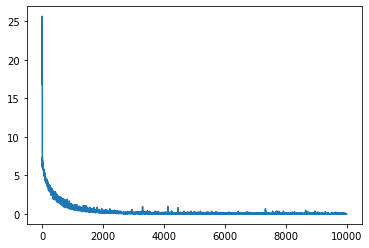

In [125]:
plt.plot(oml_loss)

# OML Test

In [72]:
sum(outer_get_params(outer_opt_state), start=[])

[(DeviceArray([[[[ 0.3384404 , -0.82582957, -0.38789916, ...,
                  -0.07805887, -0.25775382,  0.44194967]],
  
                [[ 0.01202322,  0.5633527 ,  0.09150676, ...,
                   0.44726592,  0.42234257,  0.30887455]],
  
                [[-0.91477436,  0.50434446,  0.3048939 , ...,
                   0.5095323 ,  0.1289417 , -0.31619164]]],
  
  
               [[[ 0.54833174,  0.04471398, -0.5122676 , ...,
                  -0.03777779, -0.02102205,  0.07398655]],
  
                [[ 0.25558078, -0.8773297 ,  0.13360265, ...,
                  -0.33339995, -0.13411698, -0.2727778 ]],
  
                [[ 0.00152368, -0.26909563,  0.2422013 , ...,
                  -0.41188145,  0.5928234 ,  0.33997428]]],
  
  
               [[[-0.26112506,  0.77264   , -0.21677187, ...,
                   0.49446866,  0.03249685,  0.12335216]],
  
                [[-0.8517251 , -0.7484456 ,  0.63975245, ...,
                   0.08851224, -0.11534275, -0.12729554]],
  


In [65]:
oml_params = outer_get_params(outer_opt_state)

In [71]:
len(sum(oml_params, start=[]))

15

In [68]:
oml_params[:5]

([(DeviceArray([[[[ 0.3384404 , -0.82582957, -0.38789916, ...,
                   -0.07805887, -0.25775382,  0.44194967]],
   
                 [[ 0.01202322,  0.5633527 ,  0.09150676, ...,
                    0.44726592,  0.42234257,  0.30887455]],
   
                 [[-0.91477436,  0.50434446,  0.3048939 , ...,
                    0.5095323 ,  0.1289417 , -0.31619164]]],
   
   
                [[[ 0.54833174,  0.04471398, -0.5122676 , ...,
                   -0.03777779, -0.02102205,  0.07398655]],
   
                 [[ 0.25558078, -0.8773297 ,  0.13360265, ...,
                   -0.33339995, -0.13411698, -0.2727778 ]],
   
                 [[ 0.00152368, -0.26909563,  0.2422013 , ...,
                   -0.41188145,  0.5928234 ,  0.33997428]]],
   
   
                [[[-0.26112506,  0.77264   , -0.21677187, ...,
                    0.49446866,  0.03249685,  0.12335216]],
   
                 [[-0.8517251 , -0.7484456 ,  0.63975245, ...,
                    0.08851224, -0.115

In [41]:
@jit
def compute_oml_acc(rln_params, pln_params, images, labels):
    preds = oml_net_apply(
        rln_params, pln_params, images,
    )
    corrects = (preds.argmax(-1) == labels).astype(jnp.float32)
    return corrects

def make_test_inner_loop(opt_update_fn):    
    def test_inner_loop(rln_params, pln_params, x_spt, y_spt, opt_state):
        for i, (_x, _y) in enumerate(zip(x_spt, y_spt)):
            (loss, acc), grads = value_and_grad(oml_net_xe_and_acc, 1, has_aux=True)(rln_params, pln_params, _x, _y)
            if i == 0:
                initial_loss = loss
                initial_acc = acc
            updates, opt_state = opt_update_fn(grads, opt_state, pln_params)
            pln_params = optix.apply_updates(pln_params, updates)
        return pln_params, {
            "initial_loss": initial_loss,
            "initial_acc": initial_acc,
            "final_loss": loss,
            "final_acc": acc,
            "opt_state": opt_state,
        }
    return test_inner_loop

In [42]:
val_train_images = val_images[:, :15]
val_test_images = val_images[:, 15:]
val_train_labels = val_labels[:, :15]
val_test_labels = val_labels[:, 15:]

In [126]:
test_inner_opt = optix.chain(optix.adam(1e-3))
test_inner_loop = make_test_inner_loop(test_inner_opt.update)
test_inner_loop = jit(test_inner_loop)
test_inner_opt_state = test_inner_opt.init(oml_params[1])

_, _ = test_inner_loop(
    *oml_params,
    val_train_images[:1, :1],
    val_train_labels[:1, :1],
    # flatten(val_train_images[:1], 1)[:, None, ...],
    # flatten(val_train_labels[:1], 1)[:, None, ...],
    test_inner_opt_state
)

In [128]:
# num_test_tasks = 200
num_test_tasks = val_train_images.shape[0]

new_rln_params = oml_params[0]
# new_pln_params = oml_params[1]
_, new_pln_params = oml_pln_init(rng, out_shape[0])
test_inner_opt_state = test_inner_opt.init(new_pln_params)

val_train_corrects = vmap(partial(compute_oml_acc, new_rln_params, new_pln_params))(
    val_train_images[:num_test_tasks], val_train_labels[:num_test_tasks],
).mean(-1)

val_test_corrects = vmap(partial(compute_oml_acc, new_rln_params, new_pln_params))(
    val_test_images[:num_test_tasks], val_test_labels[:num_test_tasks],
).mean(-1)

print("Accuracy before training:")
print("Train:", val_train_corrects.mean())
print("Test:", val_test_corrects.mean())

# with loops.Scope() as s:
#     for task_num in s.range(num_test_tasks):
#         for sample_num in s.range(val_train_images.shape[1]):


# pbar = tqdm(total=num_test_tasks * val_train_images.shape[1])
for task_num in tqdm(range(num_test_tasks)):
    for sample_num in range(val_train_images.shape[1]):
        new_pln_params, inner_info = test_inner_loop(
            new_rln_params,
            new_pln_params,

            # lax.dynamic_slice(val_train_images, (task_num, sample_num, 0, 0, 0), (1, 1, *val_train_images.shape[2:])),
            # lax.dynamic_slice(val_train_labels, (task_num, sample_num), (1, 1)),

            val_train_images[task_num:task_num + 1, [sample_num]],
            val_train_labels[task_num:task_num + 1, [sample_num]],
            # flatten(val_train_images[:num_test_tasks], 1)[:, None, ...],
            # flatten(val_train_labels[:num_test_tasks], 1)[:, None, ...],
            test_inner_opt_state
        )
        test_inner_opt_state = inner_info["opt_state"]
        # pbar.update()


val_train_corrects = vmap(partial(compute_oml_acc, new_rln_params, new_pln_params))(
    val_train_images[:num_test_tasks], val_train_labels[:num_test_tasks],
).mean(-1)

val_test_corrects = vmap(partial(compute_oml_acc, new_rln_params, new_pln_params))(
    val_test_images[:num_test_tasks], val_test_labels[:num_test_tasks],
).mean(-1)

print("Accuracy after training:")
print("Train:", val_train_corrects.mean())
print("Test:", val_test_corrects.mean())

Accuracy before training:
Train: 0.0017543861
Test: 0.00065789477



Accuracy after training:
Train: 0.89122814
Test: 0.48157892


AttributeError: 'DeviceArray' object has no attribute 'expand_dims'

In [82]:
val_train_images[:num_test_tasks].shape

(200, 15, 28, 28, 1)

In [76]:
test_train_corrects.mean()

DeviceArray(0.00066667, dtype=float32)

In [ ]:
new_rln_params = oml_params[0]
_, new_pln_params = oml_pln_init(rng, out_shape[0])
inner_opt_state = inner_opt.init(new_pln_params)

test_train_acc = jnp.zeros((test_images.shape[0], test_images.shape[0]))
# test_test_acc = jnp.zeros((test_images.shape[0], test_images.shape[0]))

pbar = tqdm_t(range(200))
for task_num in pbar:
    new_pln_params, inner_info = inner_loop(
        new_rln_params, new_pln_params, test_train_images[task_num, :, None, ...], test_train_labels[task_num, :, None, ...], inner_opt_state
    )
    
    test_train_corrects = vmap(partial(compute_oml_acc, new_rln_params, new_pln_params))(
        test_train_images[:task_num + 1], test_train_labels[:task_num + 1],
    ).mean(-1)
    # test_test_corrects = vmap(partial(compute_oml_acc, new_rln_params, new_pln_params))(
    #     test_test_images[:task_num + 1], test_test_labels[:task_num + 1],
    # ).mean(-1)
    
    test_train_acc = ops.index_update(test_train_acc, ops.index[task_num, :task_num + 1], test_train_corrects)
    # test_test_acc = ops.index_update(test_test_acc, ops.index[task_num, :task_num + 1], test_test_corrects)
    
    pbar.set_postfix(
        test_train_acc=test_train_corrects.mean(),
        # test_test_acc=test_test_corrects.mean(),
    )
    
    # {
    #     "initial_loss": initial_loss,
    #     "initial_acc": initial_acc,
    #     "final_loss": loss,
    #     "final_acc": acc,
    #     "opt_state": opt_state,
    # }
    
    

 65%|██████▌   | 130/200 [06:32<04:11,  3.59s/it, test_train_acc=0.18615386]